# Feature Engineering of Disease Graph | NetworkX
***Node level features that can be added***
* Node In-Degree, Out-Degree
* Number of Triangles
* Centrality
* In-betweenness
* Graphlets (?**)
*

***Links***
* Loading data in Stellargraph objects from Pandas - https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
* Algorithms for Task - https://stellargraph.readthedocs.io/en/v1.2.0/demos/index.html
* Node Classification with Directed GraphSAGE - https://stellargraph.readthedocs.io/en/v1.2.0/demos/node-classification/directed-graphsage-node-classification.html
* Unsupervised Representation Learning - https://stellargraph.readthedocs.io/en/stable/demos/embeddings/index.html#find-algorithms-and-demos-for-a-graph
* Unsupervised GraphSAGE & UnsupervisedSampler - https://stellargraph.readthedocs.io/en/v1.2.0/demos/embeddings/graphsage-unsupervised-sampler-embeddings.html
* Unsupervised DeepGraphInfoMax - https://stellargraph.readthedocs.io/en/v1.2.0/demos/embeddings/deep-graph-infomax-embeddings.html
* Data Generators | Stellargraph - https://stellargraph.readthedocs.io/en/latest/api.html#stellargraph.mapper.CorruptedGenerator
* NetworkX Node Features - https://networkx.org/documentation/stable/reference/algorithms/index.html

In [1]:
# importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
from tensorflow import keras
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from stellargraph.data import UnsupervisedSampler
from stellargraph import StellarGraph, StellarDiGraph, datasets
from stellargraph.layer import GraphSAGE, DirectedGraphSAGE, link_classification , DeepGraphInfomax, GCN
from stellargraph.mapper import DirectedGraphSAGELinkGenerator, GraphSAGELinkGenerator, GraphSAGENodeGenerator, CorruptedGenerator, FullBatchNodeGenerator


import warnings
from time import time
from IPython.display import display, HTML

warnings.filterwarnings('ignore')

In [2]:
# constants
metadata_columns = ['Diagnosis Code','Description','CMS-HCC Model Category V24']
inpatient_data_columns = ['empi','visit_id','visit_start_date','primary_diagnosis']
outpatient_data_columns = ['empi','visit_id','last_date_of_service','primary_diagnosis']

# file paths
metadata_fp = "/workspaces/graphs/graphs-eda/data/metadata/2022 Midyear_Final ICD-10-CM Mappings.csv"
inpatient_data_fp = "/workspaces/graphs/graphs-eda/data/patient-data/df_preprocessed.csv"
outpatient_data_fp = "/workspaces/graphs/graphs-eda/data/patient-data/df_outpatient.csv"

In [3]:
def prepare_metadata(metadata_fp):
    """
    Reads, cleans and prepares the HCC metadata file
    """
    # reading the risk adjustment metadata file
    metadata = pd.read_csv(metadata_fp)

    # cleaning the risk adjustment metadata file
    metadata = metadata.iloc[2:-7,:]
    metadata.replace(r'\n',' ', regex=True, inplace=True)
    metadata.reset_index(drop=True, inplace=True)

    # creating the cleaned risk adjustment metadata dataframe
    new_metadata = pd.DataFrame(metadata.iloc[1:,:])
    new_metadata.columns = metadata.iloc[0,:].tolist()

    # filtering only the required columns from patient data and metadata
    new_metadata = new_metadata.loc[:,metadata_columns]
    new_metadata.columns = ['pd','dscr','hcc']
    new_metadata.loc[:,"hcc"] = new_metadata.hcc.fillna(0).astype('int')

    return new_metadata


def prepare_patient_data(inpatient_data_fp, outpatient_data_fp):
    """
    Reads and filters only the required columns from inpatient and outpatient data
    """
    # reading the inpatient and outpatient data 
    inpatient_data = pd.read_csv(inpatient_data_fp)
    outpatient_data = pd.read_csv(outpatient_data_fp)

    inpatient_data = inpatient_data.loc[:,inpatient_data_columns]
    outpatient_data = outpatient_data.loc[:,outpatient_data_columns]

    inpatient_data.columns = ['empi','vid','vdt','pd']
    outpatient_data.columns = ['empi','vid','vdt','pd']

    return inpatient_data, outpatient_data


def create_patient_hcc_mapping(patient_df, hcc_df):
    """Maps ICD-10 codes to HCCs and prepares the data for 
    processing into adjacency matrices

    Args:
        patient_df (_type_): IP hospitalisation data
        hcc_df (_type_): HCC mapping for various (sub)models

    Returns:
        data: preprocessed data
    """
    join_params = {
    'left':patient_df,
    'right':metadata,
    'on':'pd',
    'how':'left'
    }
    data_merged = pd.merge(**join_params)
    data_hcc_dummies = pd.get_dummies(data_merged.hcc).iloc[:,1:]
    data = pd.concat([data_merged,data_hcc_dummies], axis=1)
    agg_dict = dict(zip(data_hcc_dummies.columns,np.repeat('sum', len(data_hcc_dummies.columns))))
    data = data.groupby('empi', as_index=False).aggregate(agg_dict)
    print("HCC Mapping done...")
    data.iloc[:,1:] = data.iloc[:,1:].ne(0)*1
    return data


def create_edge_table(data, metadata):
    """creates edge-table from data

    Args:
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    join_params = {
        'left':data,
        'right':metadata,
        'on':'pd',
        'how':'left'
    }

    data_combined = pd.merge(**join_params)

    data_combined['hcc'] = data_combined.hcc.replace(0,np.nan)
    data_combined = data_combined.dropna()
    data_combined = data_combined.sort_values(['empi','vdt']).reset_index(drop=True)
    data_combined["hcc_nxt"] = data_combined.hcc.shift(-1)
    index_drop = data_combined.groupby('empi').tail(1).index
    data_combined = data_combined.drop(index_drop)
    data_combined = data_combined[data_combined.hcc!=data_combined.hcc_nxt].reset_index(drop=True)

    data_combined = data_combined[['hcc','hcc_nxt']].astype(str)
    data_combined['edge'] = data_combined.hcc + ", " + data_combined.hcc_nxt
    data_combined['cnt'] = 1

    edge_data = data_combined.groupby(['hcc','hcc_nxt'], as_index=False).agg({'cnt':'count'})
    edge_data.columns = ['source','target','weight']
    
    print("Edge table preparation done...")
    return edge_data.astype(float)


def create_node_table(data):
    """Creates node table from data

    Args:
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    node_data = data.drop('empi', axis=1).sum()
    
    print("Node table preparation done...")
    return pd.DataFrame(node_data, columns=['x'])


def create_stellargraph(node_data, edge_data):

    G = StellarDiGraph({"node":node_data}, {"edge":edge_data})
    return G


def filter_edge_data_by_node(node, edge_data):
    n_i = edge_data.columns[0]
    n_j = edge_data.columns[1]
    weight = edge_data.columns[2]
    filter1 = edge_data[n_i]==node
    filter2 = edge_data[n_j]==node
    return edge_data[filter1 | filter2].sort_values(weight)


def filter_edge_data_by_source_node(node, edge_data):

    filter1 = edge_data.source==node
    return edge_data[filter1].sort_values('weight')


def filter_edge_data_by_target_node(node, edge_data):
    n_j = edge_data.columns[1]
    weight = edge_data.columns[2]
    filter1 = edge_data[n_j]==node
    return edge_data[filter1].sort_values(weight)

In [4]:
# preparing cleaned risk adjustment metadata
metadata = prepare_metadata(metadata_fp)

# filtering only the required columns from inpatient and outpatient data
inpatient_data, outpatient_data = prepare_patient_data(inpatient_data_fp, outpatient_data_fp)

In [8]:
data_combined = pd.concat([inpatient_data, outpatient_data], axis=0)

# map PD to HCC and create node and edge tables from mapped data
data_raw_graph = create_patient_hcc_mapping(data_combined, metadata)
node_data = create_node_table(data_raw_graph)
edge_data = create_edge_table(data_combined, metadata)

HCC Mapping done...
Node table preparation done...
Edge table preparation done...


In [155]:
Gd = create_stellargraph(node_data, edge_data).to_networkx()
Gu = StellarGraph(node_data, edge_data).to_networkx()
G = nx.Graph(Gd)

In [56]:
print(nx.info(Gd))
print("\n"+nx.info(Gu))

Name: 
Type: MultiDiGraph
Number of nodes: 83
Number of edges: 2752
Average in degree:  33.1566
Average out degree:  33.1566

Name: 
Type: MultiGraph
Number of nodes: 83
Number of edges: 2752
Average degree:  66.3133


In [351]:
nx.generalized_degree(G)

{1.0: Counter({20: 5, 14: 1, 21: 7, 19: 2, 18: 5, 12: 1, 15: 1}),
 2.0: Counter({20: 1,
          28: 2,
          51: 4,
          65: 1,
          59: 1,
          55: 2,
          63: 2,
          24: 1,
          67: 1,
          61: 2,
          19: 1,
          48: 2,
          40: 3,
          21: 1,
          15: 3,
          41: 2,
          47: 1,
          45: 3,
          44: 2,
          52: 2,
          32: 3,
          53: 1,
          18: 2,
          30: 1,
          6: 1,
          4: 1,
          33: 1,
          49: 1,
          12: 1,
          13: 1,
          57: 1,
          64: 2,
          38: 1,
          50: 1,
          60: 1,
          35: 2,
          46: 2,
          25: 2,
          58: 3,
          42: 2,
          16: 1,
          43: 1,
          10: 1,
          56: 1}),
 6.0: Counter({14: 3,
          28: 7,
          25: 3,
          29: 3,
          27: 3,
          22: 2,
          26: 3,
          12: 1,
          24: 2,
          23: 2,
      

In [345]:
node_features_dict = {}

node_features_dict["in_degree_centrality"] = nx.in_degree_centrality(Gd)
node_features_dict["out_degree_centrality"] = nx.out_degree_centrality(Gd)
node_features_dict["load_centrality"] = nx.load_centrality(Gd)
node_features_dict["eigenvector_centrality_numpy"] = nx.eigenvector_centrality_numpy(Gd)
node_features_dict["closeness_centrality"] = nx.closeness_centrality(Gd)
node_features_dict["current_flow_closeness_centrality"] = nx.current_flow_closeness_centrality(Gu)
node_features_dict["information_centrality"] = nx.information_centrality(Gu)
node_features_dict["betweenness_centrality_source"] = nx.betweenness_centrality_source(Gd)
node_features_dict["current_flow_betweenness_centrality"] = nx.current_flow_betweenness_centrality(Gu)
node_features_dict["approximate_current_flow_betweenness_centrality"] = nx.approximate_current_flow_betweenness_centrality(Gu)
node_features_dict["load_centrality"] = nx.load_centrality(Gd)
node_features_dict["harmonic_centrality"] = nx.harmonic_centrality(Gd)
node_features_dict["second_order_centrality"] = nx.second_order_centrality(Gu)
node_features_dict["pagerank"] = nx.pagerank_numpy(Gd)
node_features_dict["average_neighbor_degree"] = nx.average_neighbor_degree(Gd)
node_features_dict["node_clique_number"] = nx.node_clique_number(Gu)
node_features_dict["hits_numpy"] = nx.hits_numpy(Gd)[0]
node_features_dict["triangles"] = nx.triangles(G)
node_features_dict["square_clustering"] = nx.square_clustering(Gd)

# edge features
edge_betweenness_centrality_ = nx.edge_betweenness_centrality(Gd)
edge_current_flow_betweenness_centrality = nx.edge_current_flow_betweenness_centrality(Gu)
edge_load_centrality_ = nx.edge_load_centrality(Gd)

In [346]:
data = pd.DataFrame({'in_degree_centrality':pd.Series(node_features_dict['in_degree_centrality'])})
for key, value in node_features_dict.items():
    data[key] = pd.Series(value)

# data = data.fillna(np.mean(data))

In [347]:
data.to_csv("node_features.csv", index=False)

<AxesSubplot:>

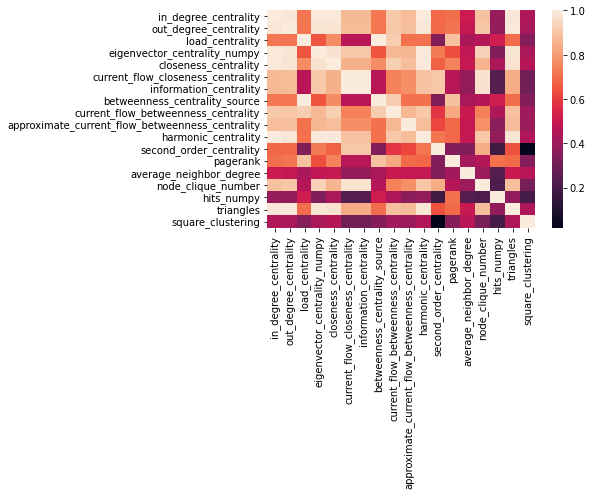

In [348]:
sns.heatmap(data.corr().abs())

In [341]:
transform = TSNE  # PCA

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(data), index=data.index)
emb_transformed["label"] = data.index

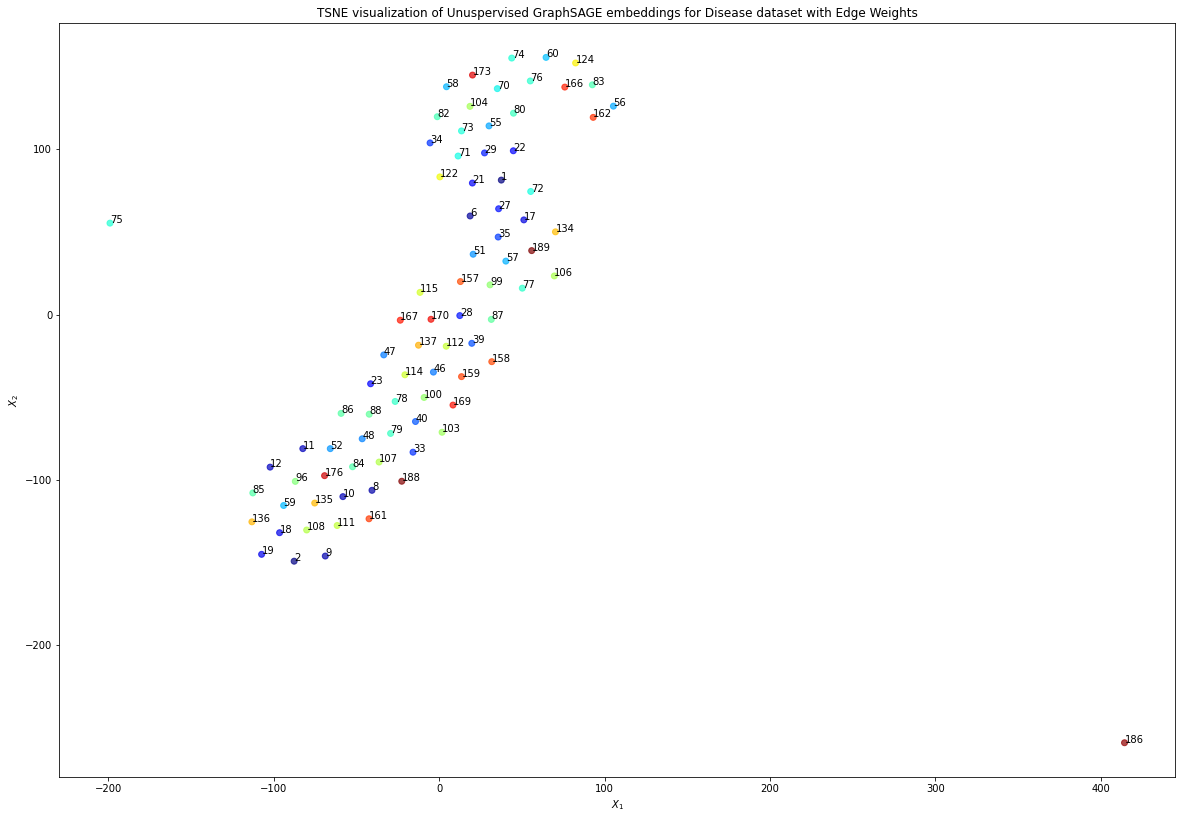

In [342]:
alpha = 0.7
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of Unuspervised GraphSAGE embeddings for Disease dataset with Edge Weights".format(transform.__name__)
)
for i, row in emb_transformed.iterrows():
    plt.annotate(int(row['label']), (row[0],row[1]))
    # print(row['label'], (row[0],row[1]))
plt.show()

{1.0: 0.3727862892755128,
 2.0: 0.2407171815675229,
 6.0: 0.40482704343589554,
 8.0: 0.28877509878235624,
 9.0: 0.234332025203202,
 10.0: 0.28058763090029465,
 11.0: 0.2613908260861243,
 12.0: 0.25492376797823174,
 17.0: 0.4,
 18.0: 0.2285733250730153,
 19.0: 0.2547251430853188,
 21.0: 0.42993816357484543,
 22.0: 0.42188698542572234,
 23.0: 0.32741428618031165,
 27.0: 0.3839777128490861,
 28.0: 0.4178668031288837,
 29.0: 0.4603199746554728,
 33.0: 0.3205725850463889,
 34.0: 0.5643800043280676,
 35.0: 0.35510595622220287,
 39.0: 0.32142909717213053,
 40.0: 0.2826248949629794,
 46.0: 0.3161779894110868,
 47.0: 0.33594696328327495,
 48.0: 0.29896969487781305,
 51.0: 0.39975206611570246,
 52.0: 0.28382989071561743,
 55.0: 0.44563225412339647,
 56.0: 0,
 57.0: 0.3741276950317675,
 58.0: 0.5797546012269938,
 59.0: 0.2605704647450378,
 60.0: 0.816793893129771,
 70.0: 0.22586691658856609,
 71.0: 0.26879823594266816,
 72.0: 0.4210009124728013,
 73.0: 0.2748771498771499,
 74.0: 0.396581196581196

In [331]:
data.T.corr().abs()

,1.0,2.0,6.0,8.0,9.0,10.0,11.0,12.0,17.0,18.0,...,162.0,166.0,167.0,169.0,170.0,173.0,176.0,186.0,188.0,189.0
1.0,1.000000,0.297405,0.984944,0.372998,0.294102,0.366435,0.358382,0.302952,0.994233,0.270565,...,0.979811,0.980134,0.715657,0.608415,0.726032,0.986237,0.376575,0.884568,0.479580,0.975000
2.0,0.297405,1.000000,0.457888,0.996707,0.999994,0.997307,0.997890,0.999979,0.397879,0.999608,...,0.106042,0.106460,0.879631,0.938628,0.872433,0.136580,0.996449,0.707956,0.980416,0.501019
6.0,0.984944,0.457888,1.000000,0.527651,0.454810,0.521665,0.514270,0.463044,0.997738,0.432823,...,0.931677,0.932031,0.825550,0.736375,0.833926,0.943082,0.530954,0.951719,0.623981,0.998442
8.0,0.372998,0.996707,0.527651,1.000000,0.996433,0.999945,0.999865,0.997185,0.470225,0.994073,...,0.184836,0.185330,0.914974,0.963264,0.908804,0.215365,0.999969,0.762485,0.993002,0.569016
9.0,0.294102,0.999994,0.454810,0.996433,1.000000,0.997052,0.997666,0.999955,0.394710,0.999699,...,0.102566,0.102988,0.877987,0.937434,0.870740,0.133137,0.996157,0.705528,0.979730,0.498043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173.0,0.986237,0.136580,0.943082,0.215365,0.133137,0.208546,0.200073,0.142294,0.962855,0.108797,...,0.999122,0.999280,0.591048,0.469688,0.603132,1.000000,0.219228,0.795541,0.328914,0.924875
176.0,0.376575,0.996449,0.530954,0.999969,0.996157,0.999938,0.999807,0.996932,0.473590,0.993708,...,0.188896,0.189356,0.916513,0.964305,0.910422,0.219228,1.000000,0.764870,0.993492,0.572050
186.0,0.884568,0.707956,0.951719,0.762485,0.705528,0.757786,0.752162,0.712102,0.929475,0.687922,...,0.775344,0.775892,0.958640,0.908088,0.962719,0.795541,0.764870,1.000000,0.833140,0.965903
188.0,0.479580,0.980416,0.623981,0.993002,0.979730,0.992185,0.991067,0.981547,0.570743,0.974520,...,0.299500,0.299954,0.956074,0.988173,0.951596,0.328914,0.993492,0.833140,1.000000,0.661588
